In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime as dt
import numpy as np

from scipy import stats
from sklearn import cluster

sns.set(rc={'figure.figsize':(14, 7)})

from IPython.display import display

Т.к данные весят не так уж и много, то для удобства читаем их в датафремы, переводим время в datetime для дальнейшей работы, удаляем "битые" наблюдения

In [2]:
df_dle_users = pd.read_csv('data/copy_dle_users.csv')
df_dle_users.reg_date = pd.to_datetime(df_dle_users.reg_date, unit='s')
df_dle_users = df_dle_users.query('reg_date > 1970')\
                                               .rename(columns={'name' : 'login'})

df_characters = pd.read_csv('data/copy_ms_characters.csv')
df_characters.created_at = pd.to_datetime(df_characters.created_at)
df_characters = df_characters.query('created_at.dt.year > 1970')

Посчитаем кол-во персонажей на каждом аккаунте

In [3]:
df_char_per_acc = df_characters.groupby('login', as_index=False)[['username']].nunique()
quantile90 = df_char_per_acc.username.quantile(0.9)

Так как на 90% аккаунтов находится {{ quantile90 }} или меньше персонажей, то логично отфильтровать выборку по этому значению, чтобы избежать влияния выбросов в дальнейшем 

In [4]:
df_char_per_acc  = df_char_per_acc .query('username <= 3')
df_characters = df_characters.query('login in @df_char_per_acc.login')
df_lur = pd.merge(df_dle_users, df_characters, how='inner', on='login')
df_lur['year'] = df_lur.reg_date.dt.year

Соберем таблицу логин + персонажи на аккаунте +дата регистрации, основываясь на отфильтрованных данных. Плюс соберем воедино старые и новые записи

Для начала разобьем игроков на когорты.
Допустим, по времени регистрации. Так как время регистрации у нас начинается с 2015 года, то сначала выберем годовой промежуток

In [5]:
df_cohort_uniq = df_lur.groupby('year', as_index=False)[['login', 'username']].nunique()
melted_df = df_cohort_uniq[['year', 'login', 'username']].melt(id_vars=['year'], value_vars=['login', 'username'])
df_cohort_uniq

,year,login,username
0,2015,1927,2389
1,2016,7191,9059
2,2017,8763,11894
3,2018,11275,15825
4,2019,15966,22554
5,2020,20444,32474
6,2021,100034,129683
7,2022,46126,55949


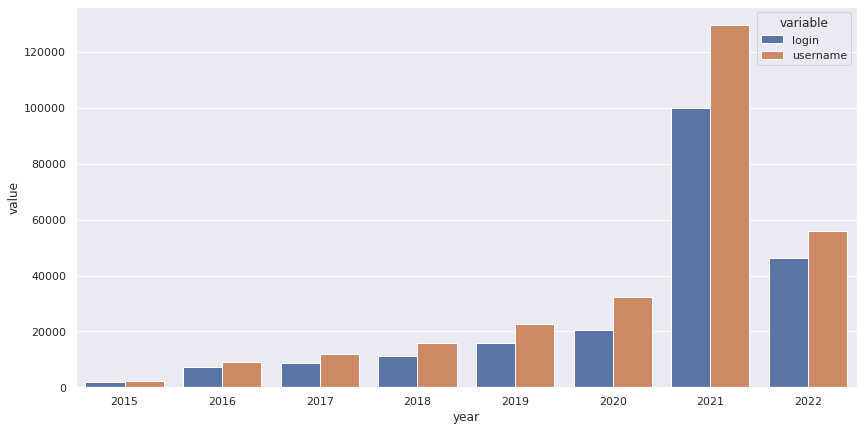

In [6]:
sns.barplot(x='year', y='value', data=melted_df , hue='variable')
plt.show()

Как видим, число уникальных аккаунтов, а вместе с тем и количество новых персонажей только росло от года к году, 22 год только начался, а число желающих жить на пустошах уже достигло почти половины от прошлогоднего показателя. 


#### Продолжительность сессий <br>
Добавим в таблицу с данными о времени начала и конца сессии данные о создании аккаунта и посчитаем разницу между началом и концом сессии, сгруппируем по году создания персонажа и рассчитаем среднее значение timedelta в секундах.

In [7]:
df_session_duration = pd.read_csv('data/copy_mc_session_durations1.csv')
df_session_duration1 =pd.read_csv('data/copy_mc_session_durations2.csv').drop('sliding_power', axis=1)

df_session_duration_u = pd.concat([df_session_duration, df_session_duration1])
df_session_duration_u.session_start = pd.to_datetime(df_session_duration_u.session_start)
df_session_duration_u.session_end = pd.to_datetime(df_session_duration_u.session_end)
del df_session_duration, df_session_duration1

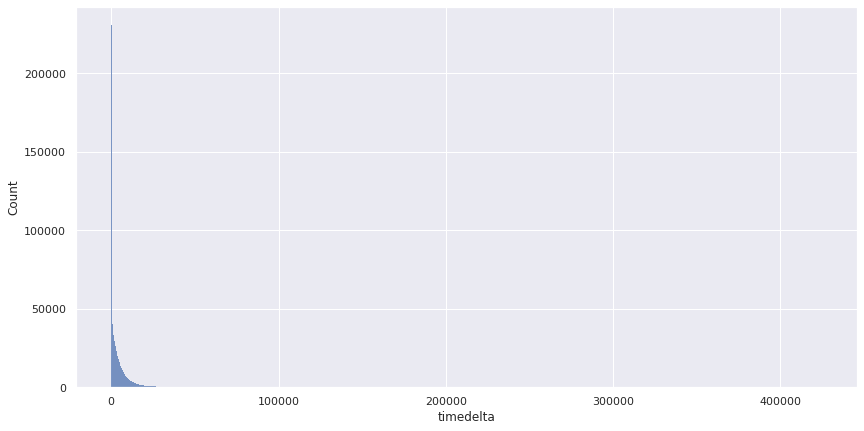

In [8]:
# таблица с продолжительностью сессий, персонажами и временем регистрации акк-а и временем создание перса
df_duration_reg_year = pd.merge(df_session_duration_u, df_lur[['username', 'created_at', 'reg_date']], on='username')
df_duration_reg_year['year_created'] = df_duration_reg_year.created_at.dt.year 
df_duration_reg_year['year_reg'] = df_duration_reg_year.reg_date.dt.year

# подсчет времени между концом и началом сессии в секундах
df_duration_reg_year['timedelta'] = (df_duration_reg_year['session_end'] - df_duration_reg_year['session_start']).dt.total_seconds()

# пока нам не нужны исходные таблицы, мы их удалим, чтобы не забивали оперативку
del df_session_duration_u

sns.histplot(data=df_duration_reg_year, x='timedelta',binwidth=60)
plt.show()

И так, мы наблюдаем сильную ассиметрию в распределении, т.о. понятие среднего к этой выборке неприменимо. Первым делом удалим все нулевые сессии и оставим все, что больше одной минуты. 

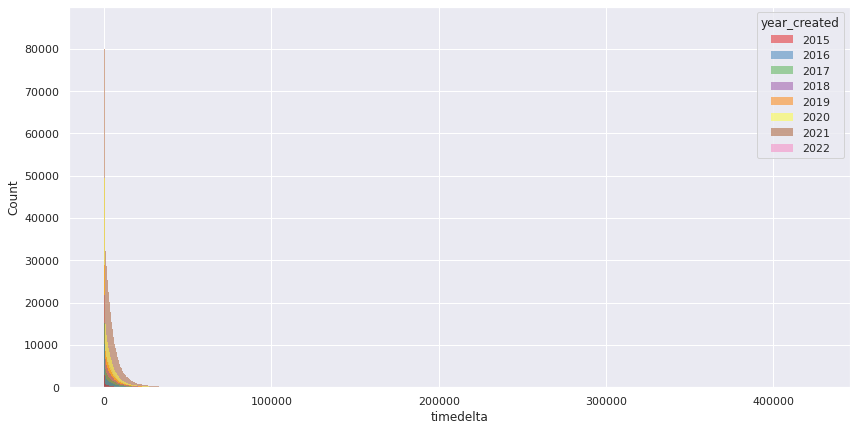

In [9]:
df_duration_reg_year= df_duration_reg_year.query('timedelta >= 60')
sns.histplot(data=df_duration_reg_year, 
                     x='timedelta',
                     binwidth=120, 
                     hue='year_created',
                     palette='Set1',
                     edgecolor='none')
plt.show()

Отлично. Ничего не поменялось :D Рассчитаем 0,05 квантиль, медиану и межквантильный интервал для игроков разных лет регистрации

In [10]:
# вариант, если надо сделать много кастомных агрегирующих функций
def interquan(x,l=0.25,h=0.75):
    qrange=x.quantile([l, h])
    return(f'{qrange[l]:.0f} - {qrange[h]:.0f}')

df_quant = df_duration_reg_year.groupby('year_created', as_index=False)[['timedelta', 'username']]\
                                                        .agg(quantile005=('timedelta',lambda x:np.quantile(x,0.05)),
                                                                char_count=('username','count'),
                                                                timedelta_med = ('timedelta', 'median'),
                                                                inter_timedelta = ('timedelta', lambda x:interquan(x)),
                                                                max_session_dur = ('timedelta', 'max'))

#я хотел вывести таблички в markdown, но у меня почему-то не подтягиваются переменные в ячейку markdown
# простой вариант с describe, но мне захотелось так
# df_duration_reg_year.groupby('year_created')['timedelta'].describe(percentiles = [0.05, 0.25, 0.5, 0.75]).drop(['mean', 'std'], axis=1)
df_quant

,year_created,quantile005,char_count,timedelta_med,inter_timedelta,max_session_dur
0,2015,155.0,38839,2662.0,677 - 6734,367758.0
1,2016,153.0,137244,2625.0,637 - 6489,303319.0
2,2017,163.0,222314,2905.0,815 - 6898,286143.0
3,2018,161.0,329486,2875.0,817 - 6815,373644.0
4,2019,162.0,441506,2869.0,828 - 6761,424489.0
5,2020,163.0,756633,2862.0,849 - 6618,294666.0
6,2021,179.0,1699345,3256.0,1185 - 6947,341116.0
7,2022,214.0,436767,3709.0,1479 - 7584,299780.0


Из приведенной таблички видно, что 5% сессий длится от  2,5 до 3,5 минут в зависимости от года регистрации, причем чем старше пресонаж, тем меньше количество таких сессий у этого персонажа. Как мне подсказали, это связано с посещением внутриигрового аукциона. Количество сессий в зависмости от года регистрации (char_count) растет от года к году, что отлично бьется с первой диаграммой, показывающей количество зарегистрированных пользователей. Так же среднее время (в нашем случае медиана) провождения в игре у новых игроков выше почти на  20 минут  (61 минута у игроков, зарегестрированных в 2022 году против 44 минут у игроков с 2015 года). В большинстве случаев игроки разных лет проводят в игре от 10-25 минут до 2 часов, причем тут тоже сохраняется тенденция: чем новее игрок, тем больше времени он проводит в игре. Если рассмотреть максимальные продолжительности сессий, то строгой закономерности выявить не удается, стоить отметить, что эти сессии длятся по 90+ часов. Вероятно, это могут быть игроки, которые просто не завершают активную сессию после того, как отходят от пк (afk players), либо боты, либо трейдеры. К сожалению, из-за незнания внутренних механик игры точнее сказать не могу.

### Рассмотрим параметр open rating influence <br>
Он находится в табличке session_duration_u (объединенные старые и новые данные). Совеместим данные о продолжительности сессий с данными о силе и влиянии игрока

In [11]:
df_sliding_power = pd.read_csv('data/copy_mc_player_sliding_power.csv')
df_sliding_power1 = pd.read_csv('data/copy_mc_player_sliding_power1.csv')

df_sliding_u = pd.concat([df_sliding_power, df_sliding_power1])
df_sliding_u.date = pd.to_datetime(df_sliding_u.date)

del df_sliding_power, df_sliding_power1

In [12]:
# таблица персонажем, врменем его создания, временем регистрации акк-а, временем сессии
df_sd_ori = pd.merge(df_duration_reg_year[['username', 'year_created', 'timedelta', 'year_reg']],
                                     df_sliding_u.drop(['current_gear_power', 'id'], axis=1),
                                     how='inner',
                                     on='username')

Для начала вообще посмотрим, как распределяются игроки по своему влиянию и времени, проведенному в игре на момент последнего наблюдения.

In [13]:
# датафрем для того, чтобы посмотреть, сколько было наиграно секунд игроком на момент последней записи лога
df_sd_ori_last = df_sd_ori.sort_values('date')[['username', 'date', 'play_time_seconds']]\
                                            .groupby('username', as_index=False).last()
print(f"{df_sd_ori_last['username'].nunique()} уникальных персонажей на данный момент")

131326 уникальных персонажей на данный момент


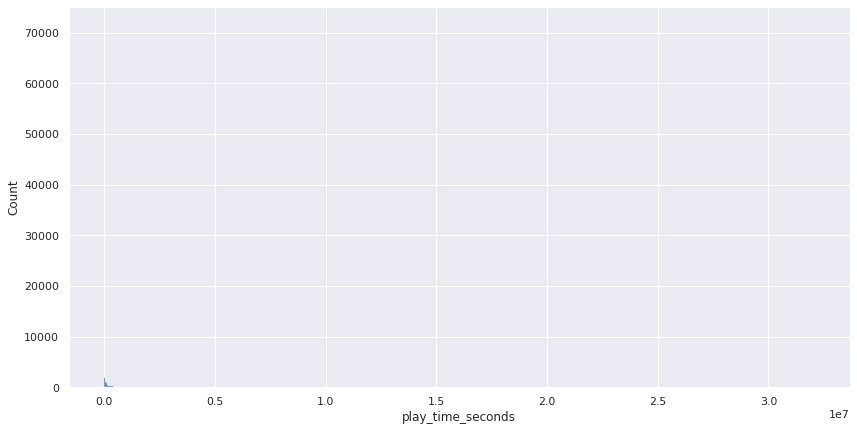

In [14]:
sns.histplot(data=df_sd_ori_last, 
                     x = 'play_time_seconds', 
                     edgecolor='none')
plt.show()

Вероятно, у нас битые логи, присмотримся к данным внимательнее. кажется, нулевые значения нам не подходят. 
В данной ситуации нас интересуют активные игроки и игроки, которые провели в игре хотя бы час (походили, что-то посмотрели и дропнули). 

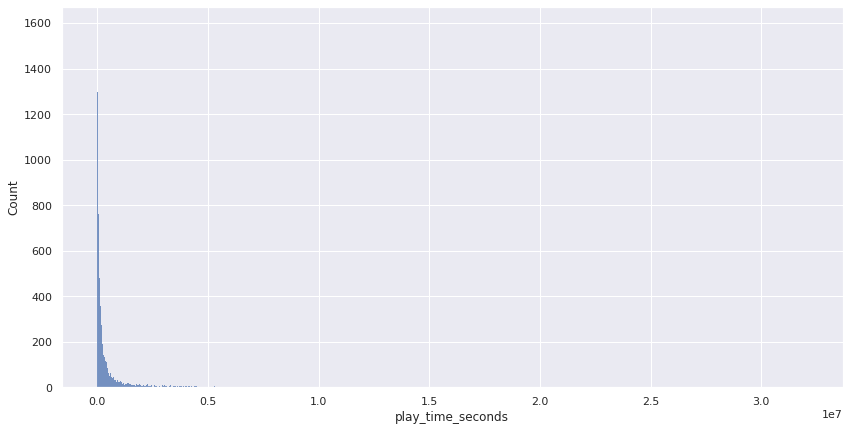

In [15]:
df_sd_ori_last = df_sd_ori_last.query('play_time_seconds >= 60*60')
sns.histplot(data=df_sd_ori_last, 
                     x=df_sd_ori_last.play_time_seconds, 
                     binwidth=3600,
                     edgecolor='none')
plt.show()

In [16]:
print(df_sd_ori_last['play_time_seconds'].describe().drop(['mean', 'std']))
df_sd_ori= pd.merge(df_sd_ori_last['username'], df_sd_ori, on = 'username', how='left')
# отлично, выбросили ненужные данные, теперь разберемся с агрессивностью игроков

count       60251.0
min          3600.0
25%         52598.0
50%        151781.0
75%        483310.0
max      32080380.0
Name: play_time_seconds, dtype: float64


In [17]:
# агреггируем наши данные, посчитаем медиану длинны сессии для каждого игрока, значение силы и агрессии на момент записи последнего лога.
df_sd_ori = df_sd_ori.sort_values('date')\
                                    .groupby('username', as_index=False)\
                                    .agg({ 'date':'last',
                                              'year_created':'last',
                                              'year_reg':'last',
                                              'timedelta':'median',
                                              'play_time_seconds':'last',
                                              'sliding_power':'last',
                                              'openworld_rating_influence':'last'})

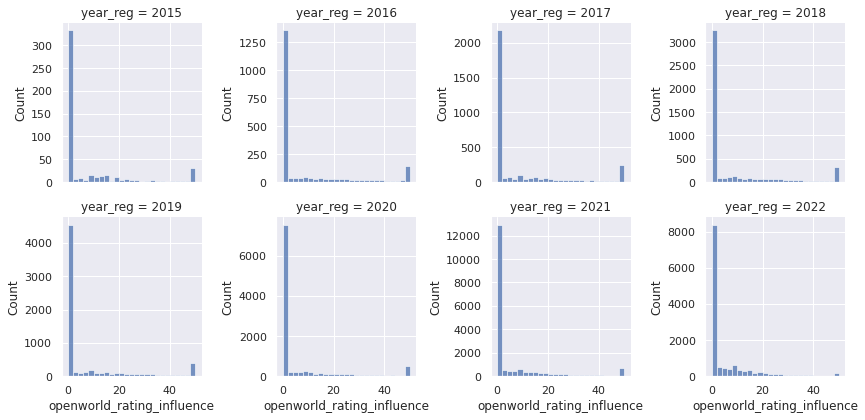

In [18]:
#sns.FacetGrid(data=df_sd_ori_last, x='sliding_power', binwidth=100, hue='year_created', multiple='dodge', palette='Set1', kde=True)
fg = sns.FacetGrid(df_sd_ori,
                               col='year_reg', 
                               col_wrap=4, 
                               sharey=False)
fg.map(sns.histplot, 'openworld_rating_influence', binwidth=2)
plt.show()

Как видно из гистограмм поведение игроков в зависимости от года в основном не меняется (что также говорит о плохом выборе признака для разделения на когорты в данном случае). Отсюда видно, что большая масса игроков все же склонна к мирному существованию - 75% из общей выбоки имеют рейтинг ниже 8.1. Остальные же пк-шат пока не упираются в верхнюю планку, либо пока их не начнут сливать другие игроки. <br>
Самым очевидным на первый взгляд будет сопоставить силу/время,проведенное в игре и рейтинг

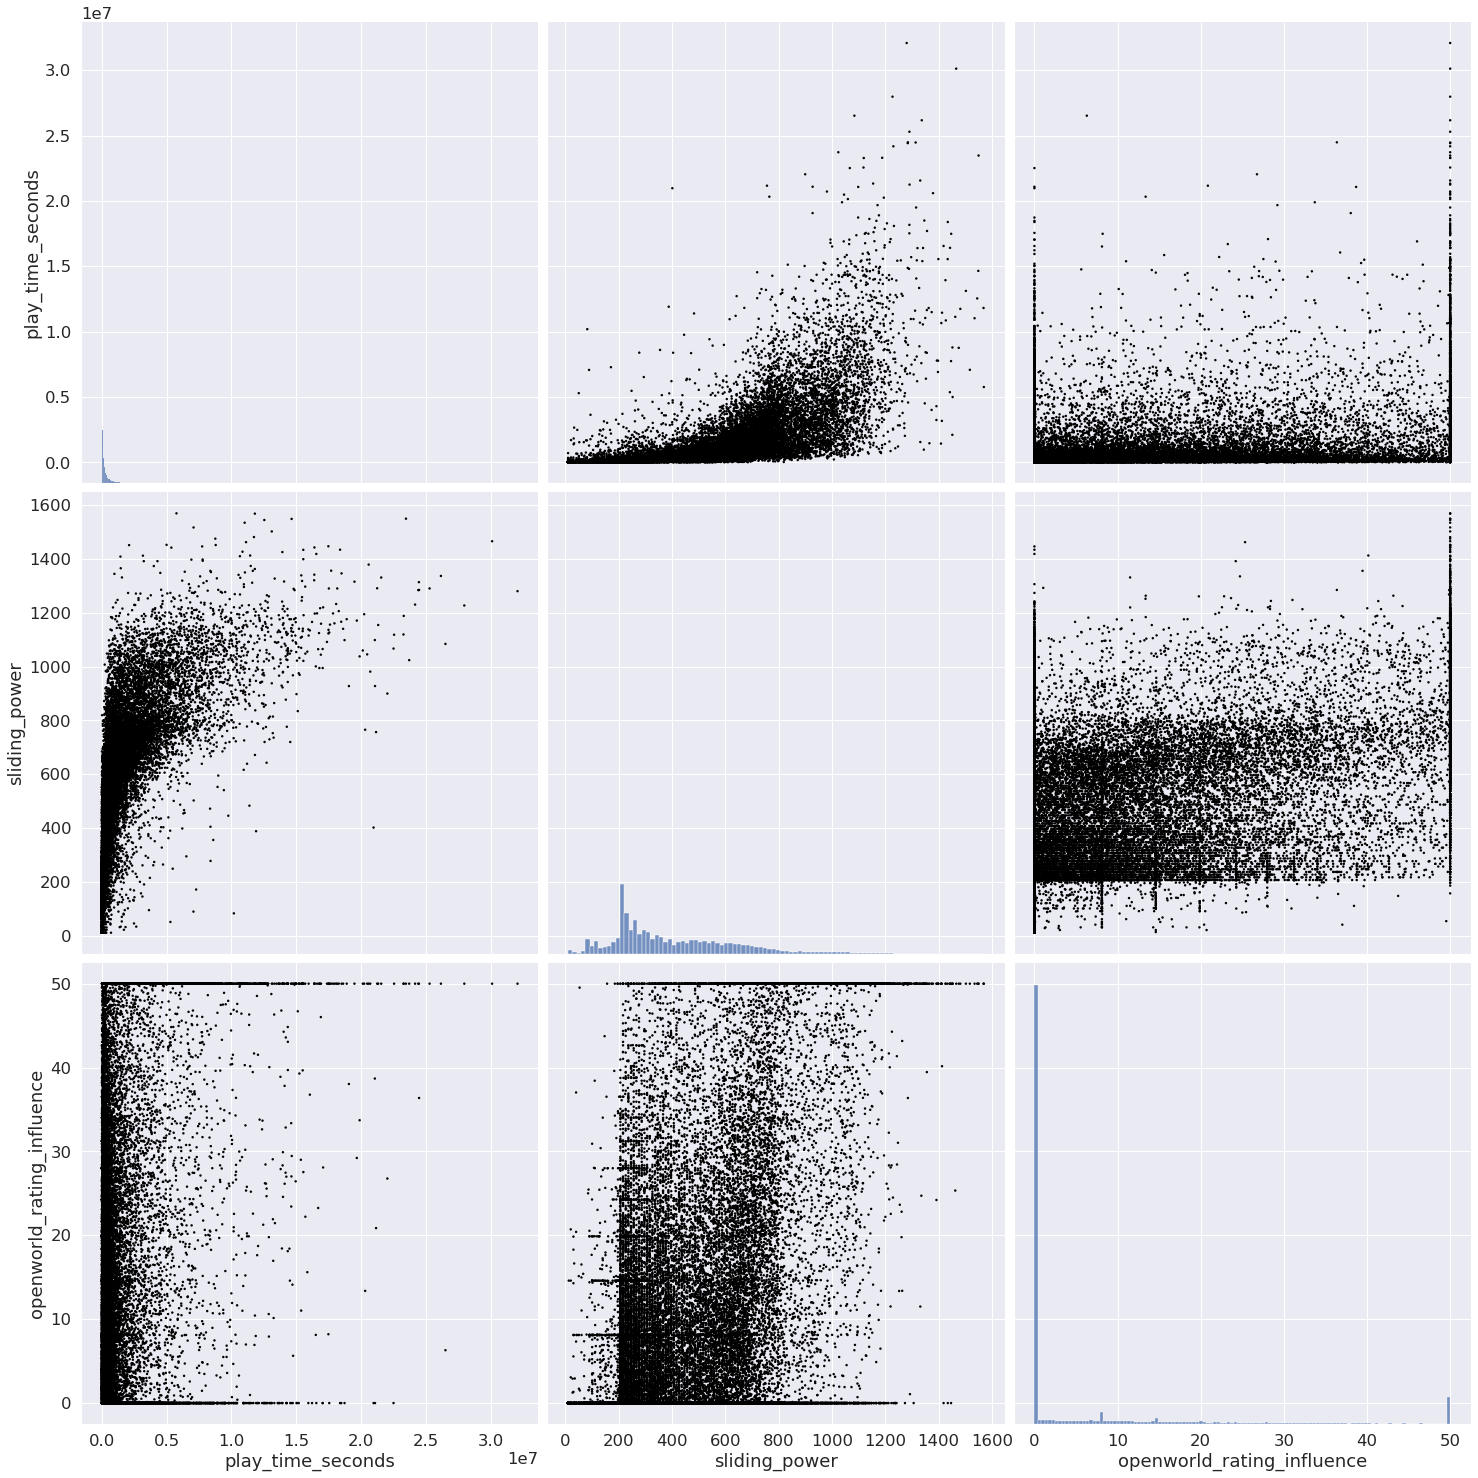

,play_time_seconds,sliding_power,openworld_rating_influence
count,60251.0,60251.000,60251.00000
min,3600.0,10.450,0.00000
25%,52598.0,226.538,0.00000
50%,151781.0,332.753,0.00000
75%,483310.0,545.284,8.11555
max,32080380.0,1569.870,50.00000


In [19]:
sns.set(font_scale=1.5)
pf = sns.pairplot(df_sd_ori[['play_time_seconds', 'sliding_power', 'openworld_rating_influence']], 
                             height=7,
                             plot_kws={'edgecolor':'none', 's':6, 'facecolor':'black'})
plt.show()
df_sd_ori[['play_time_seconds', 'sliding_power', 'openworld_rating_influence']].describe().drop(['mean', 'std'])

Из данных графиков можно выделить несколько поинтов, которые надо рассмотреть в дальнейшем. Во-первых, персонажи стартуют не с нулевой силой, она равна ~ 200, что объясняет, почему только созданные персонажи могут пк-шить и имеют рейтинг 50 при очень малом времени игры (сразу возникает вопрос, есть ли связь между временем создания аккаунта и такого поведения в игре *я посмотрел - нет, все также). Во-вторых, в системе учета рейтинга есть пороги, которые игрок должен преодолеть, чтобы его повысило на следующий уровень агресии. Первый порог находится в районе 8, что соответствует 75% процентилю, т.е. большинство игроков не переходит его. Из очевидного, если посмотреть на график время в игре/сила, то видно, что чем больше игрок проводит в игре, тем сильнее он становится.

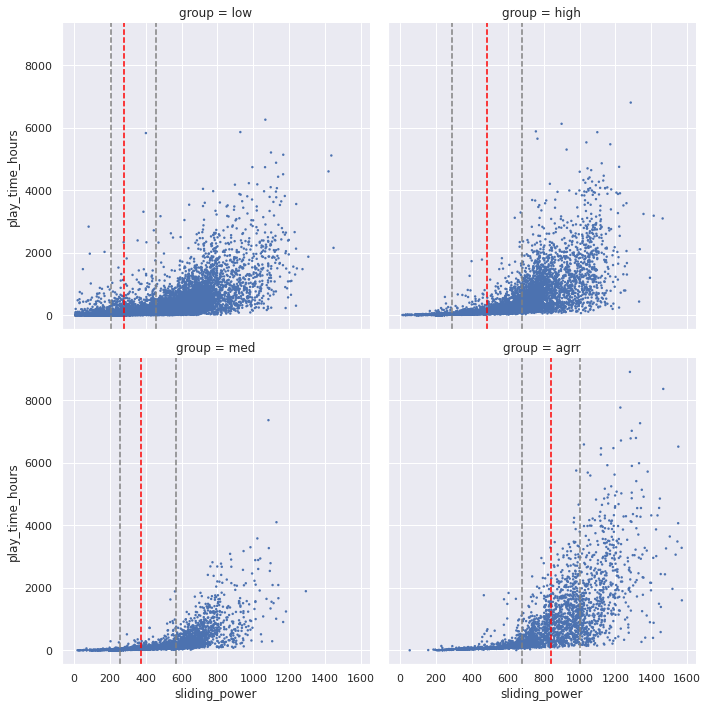

play_time_hours                                                 \
                count        mean          std       min         25%   
group                                                                  
agrr           2513.0  984.515914  1139.305488  3.653889  179.240278   
high          12705.0  283.577126   536.866256  1.341944   28.254444   
low           38933.0  112.690345   292.453831  1.000000   10.457778   
med            6100.0  155.685689   326.753188  1.690000   21.923819   

                                             
              50%          75%          max  
group                                        
agrr   563.459444  1393.002778  8911.216667  
high    81.366389   269.770556  6801.377222  
low     29.741667    85.159722  6254.074167  
med     52.195833   134.254653  7367.053333

sliding_power                                                       \
              count        mean         std      min       25%       50%   
group                                                                      
agrr         2513.0  831.433352  249.306376  53.5785  677.2250  842.8330   
high        12705.0  504.251799  236.100061  13.0276  286.6770  481.8920   
low         38933.0  336.563045  186.808615  10.4500  206.5260  280.3280   
med          6100.0  421.690350  190.102673  20.4621  256.6015  376.7385   

                            
              75%      max  
group                       
agrr   1000.41000  1569.87  
high    677.26500  1462.70  
low     456.87100  1446.89  
med     566.96825  1292.79

In [20]:
# поппытался грубо разделить на группы по агрессивности и прикинуть отношение затраченного времени на игру и силе.
# первая группа - 0ori, вторая - 75%, третья от 75% до 98%, четвертая все >98%
test = df_sd_ori.copy()
test['group'] = np.where(df_sd_ori.openworld_rating_influence ==0, 'low',
                        np.where(df_sd_ori.openworld_rating_influence <= 8.1, 'med',
                        np.where(df_sd_ori.openworld_rating_influence <= 48, 'high', 'agrr')))  

# переведем секунды в часы для удобного восприятия
test['play_time_hours'] = test.play_time_seconds/3600

sns.set(font_scale=1)
fg = sns.FacetGrid(data=test, col='group', col_wrap=2, height=5)
fg.map(sns.scatterplot, 'sliding_power',  'play_time_hours', s=6, edgecolor='none')

def show_med(x, **kwargs):
    plt.axvline(x.quantile(0.5), c='red', ls='--')
    plt.axvline(x.quantile(0.75), c='grey', ls='--')
    plt.axvline(x.quantile(0.25), c='grey', ls='--')

fg.map(show_med, 'sliding_power')    
    
plt.show()

display(test.groupby('group')[['play_time_hours']]\
      .describe())
display(test.groupby('group')[['sliding_power']]\
      .describe())

Как видно из гистограмм между группами есть существенные различия. Группа неагрессивных игроков 'low' самая многочисленная (~39к), при этом среднее время (здесь и далее имеется в виду медиана), проведенное в игре является самым низким около 30 часов, то же самое относится и к силе игроков в этой группе - в среднем она составляет 280 единиц. По мере нарастания агрессивности групп наблюдается рост уровня силы и среднего времени, проведенного в игре. Но больше всего отличается группа с самым высоким ORI, это игроки, которые в среднем провели в игре более 550 часов, для сравнения, в предыдущей группе этот показатель колеблется в районе 80 часов. Также показатель их силы почти в два раза превосходит прошлую группу (843 против 482). в этой же группе находится самый сильный игрок с показателем силы 1569 (тот, что 1647.52 отлетел вместе с твинками).   <br>
Раз мы затронули тему силы, то рассмотрим, как же распределяется сила персонажей, созданных в разные годы

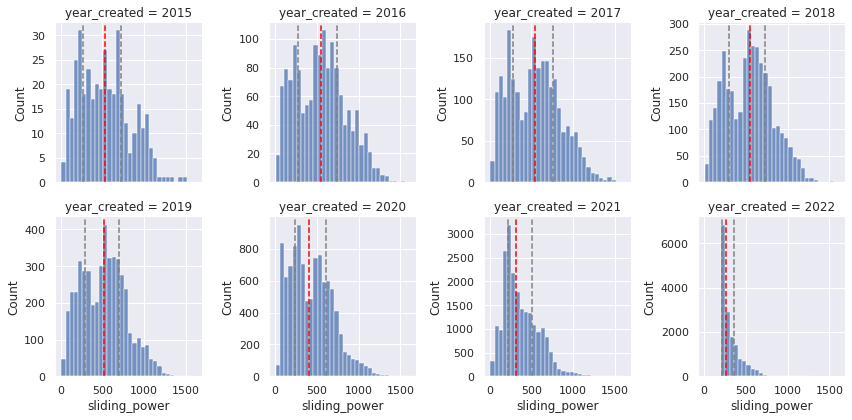

In [21]:
fg = sns.FacetGrid(data=test, col='year_created', col_wrap=4, sharey=False)
fg.map(sns.histplot, 'sliding_power', binwidth=50)
fg.map(show_med, 'sliding_power')    
plt.show()

Если рассматривать распределение силы без разделения на годы (см. pairplot), то видно только унимодальное распределение, похожее на нормальное с правосторонней ассиметрией, но при разделении ряда на годовые выборки разной длинны, то сразу наблюдается бимодальное распределение по силе во всех случаях, кроме последних двух лет. А так как за последние у нас имеется самое большое количество наблюдений, то в общей ситуации они перетягивают силы к значению ~250. Попробуем разделить выборку по параметрам play_time_hours и sliding_power, для этого применим кластерный анализ методом kmeans из-за его простоты и скорости работы. 

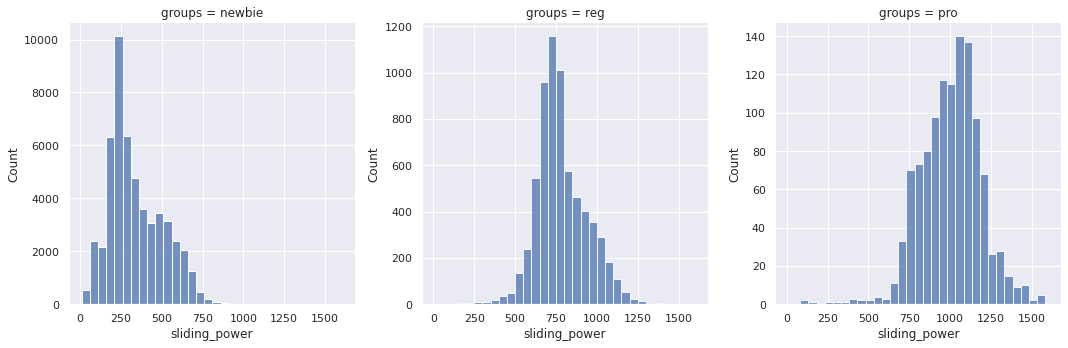

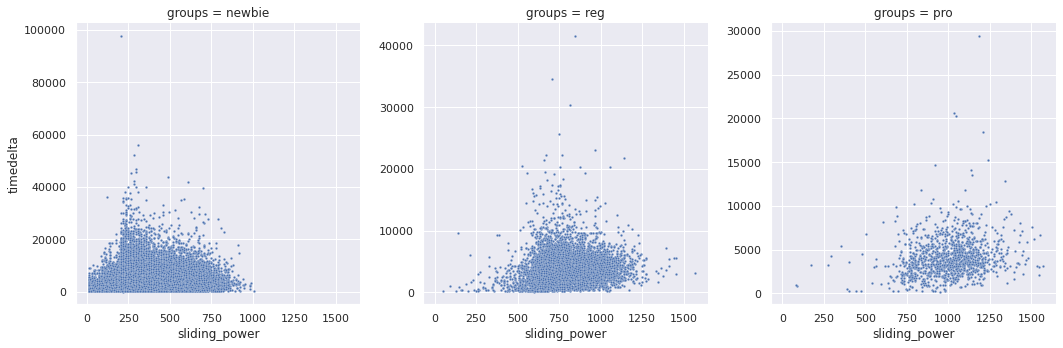

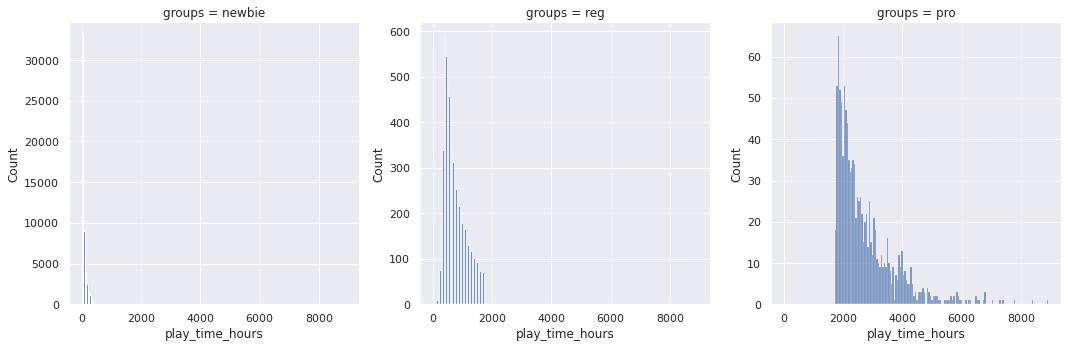

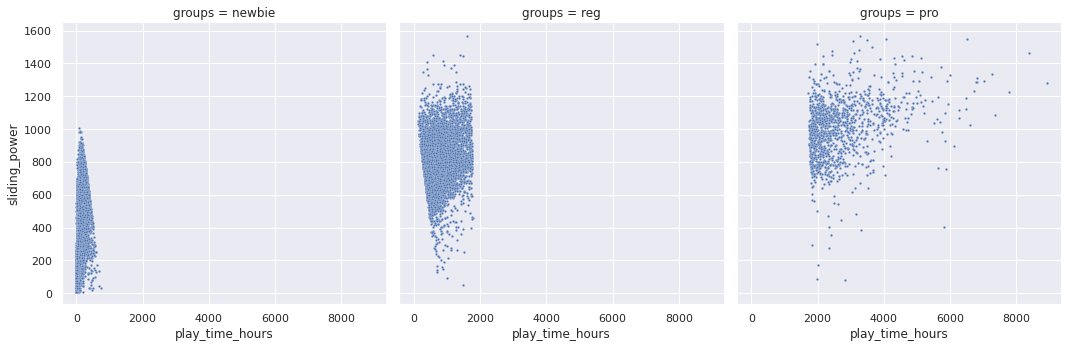

sliding_power


,count,mean,std,min,25%,50%,75%,max
groups,,,,,,,,
newbie,52442.0,339.441989,164.422393,10.450,216.5330,296.624,460.0535,1007.51
pro,1154.0,1003.839021,186.092823,82.500,882.8925,1017.810,1122.4700,1568.75
reg,6655.0,783.198236,155.426079,50.565,684.9845,757.481,876.5195,1569.87


timedelta


,count,mean,std,min,25%,50%,75%,max
groups,,,,,,,,
newbie,52442.0,4062.871811,3583.165939,85.0,1632.0,3390.00,5495.75,97877.0
pro,1154.0,4168.498700,2348.805374,206.5,2729.5,3776.75,5219.75,29484.0
reg,6655.0,3890.198573,2564.782314,129.0,2260.0,3470.00,4983.25,41614.5


play_time_hours


,count,mean,std,min,25%,50%,75%,max
groups,,,,,,,,
newbie,52442.0,61.912902,74.642287,1.000000,12.262708,32.447778,81.370347,740.161667
pro,1154.0,2736.977570,1006.172085,1714.439722,2025.936875,2397.600278,3102.692708,8911.216667
reg,6655.0,752.619567,373.489098,110.886111,451.351111,651.117222,989.172639,1777.369167


In [22]:
test = df_sd_ori.copy()
test['play_time_hours'] = test.play_time_seconds/3600

clust = test[['play_time_hours', 'sliding_power']]
kmeans= cluster.KMeans(n_clusters=3,)
kmeans.fit(clust)

test['groups'] = kmeans.predict(clust)
med_criteria = test.groupby('groups', as_index=False)['sliding_power'].median()

# жуткая жуть, чтобы переназвать группы по критерию медианы
test['groups'] = np.where(test.groups == med_criteria[med_criteria.sliding_power == med_criteria.sliding_power.min()]['groups'].index.values[0], 'newbie',
                          np.where(test.groups == med_criteria[med_criteria.sliding_power == med_criteria.sliding_power.max()]['groups'].index.values[0], 'pro', 'reg'))


    
fg = sns.FacetGrid(data=test, col='groups', col_wrap=3, sharey=False, height=5)
fg.map(sns.histplot, 'sliding_power', binwidth=50) 
plt.show()

fg = sns.FacetGrid(data=test, col='groups', col_wrap=3, height=5, sharey=False)
fg.map(sns.scatterplot, 'sliding_power', 'timedelta', s=6)
plt.show()

fg = sns.FacetGrid(data=test, col='groups', col_wrap=3, sharey=False, height=5)
fg.map(sns.histplot, 'play_time_hours', binwidth=50)
plt.show()

fg = sns.FacetGrid(data=test, col='groups', col_wrap=3, height=5)
fg.map(sns.scatterplot, 'play_time_hours', 'sliding_power', s=6)
plt.show()

print('sliding_power')
display(test.groupby('groups')['sliding_power'].describe())

print('timedelta')
display(test.groupby('groups')['timedelta'].describe())

print('play_time_hours')
display(test.groupby('groups')['play_time_hours'].describe())

Мы получили три группы игроков, которые можно охарактеризовать как "новички" или "начавшие и бросившие", "развивающиеся игроки" и кхм.., пусть будут,  "ветераны". Группа новичков самая многочисленная 52.5к персонажей находятся именно в ней, она характерна наименьшими показателями силы - 296 у.е. длинны сессии - 3390 секунд и времени, проведенного в игре - ~12 часов. Игроки, которые провели в игре от 450 часов уже попадают в группу "развивающихся игроков". Средний показатель силы уже далек от стартовых 200 и равняется 757 у.е., в среднем в игре они уже провели 650 часов. Ветераны провели в игре уже больше 2000 часов, средний показатель силы в их группе около 1017, также среднее время одной сессии у них тоже самое больше 3776 секунд.

#### Посмотрим струтуру  DAU(Daily active users) - WAU(Weekly active users) - MAU(Monthly active users), используя нашу прошлую разбивку по силе игроков

In [98]:
# собираем df из прошлого датасета, разбитого по группам и отфильтрованного по времени в игре + используем 
# датасет по продолжительности сессий, добавляем отдельно месяц, год, день и неделю года. Это поможет в 
# дальнейшем при группировке

df_activity = pd.merge(test[['username', 'groups', 'sliding_power']], 
                                  df_duration_reg_year[['username', 'session_start', 'session_end', 'timedelta']],
                                  on='username')
df_activity['year'] = df_activity.session_start.dt.year
df_activity['month'] = df_activity.session_start.dt.month
df_activity['week'] =  df_activity.session_start.dt.isocalendar().week
df_activity['day'] = df_activity.session_start.dt.day

In [110]:
# много повторяющегося кода :( хотелось бы узнать, как генерировать такие датасеты в цикле или еще как-то
# создаем отдельные df для дневной, недельной и месячной активностей. В них будут входить кол-во 
# уникальных пользователей в день, общее количество сессий, медиана продолжительности сессии и медиана   
# суммарного времени каждого игрока в разбивке по силе и по периодам активности. 

df_dau = df_activity.groupby(['groups', 'year', 'month', 'day'], as_index=False)\
                                 .agg(users_per_day = ('username', 'nunique'),
                                         sessions_per_day = ('session_start', 'count'),
                                         med_session_time = ('timedelta', 'median'),)
df_wau = df_activity.groupby(['groups', 'year', 'week'], as_index=False)\
                                 .agg(users_per_day = ('username', 'nunique'),
                                         sessions_per_day = ('session_start', 'count'),
                                         med_session_time = ('timedelta', 'median'))
df_mau = df_activity.groupby(['groups', 'year', 'month'], as_index=False)\
                                 .agg(users_per_day = ('username', 'nunique'),
                                         sessions_per_day = ('session_start', 'count'),
                                         med_session_time = ('timedelta', 'median'),)
df_dau['date'] = pd.to_datetime(df_dau[['year', 'month', 'day']])
df_wau['date'] = df_wau.year.astype('str') + ' - ' + df_wau.week.astype('str')
df_mau['date'] = df_mau.year.astype('str') + ' - ' + df_mau.month.astype('str')


def sum_med_period(df_act, df, grouper):
# эта функция считает сначала суммарное время, проведенное игроком в игре, а потом считает медиану 
# этих значений в группе
    
    grouper.append('groups')
    df1 = df_act.groupby(grouper + ['username'], 
                               as_index=False).sum()\
                             .groupby(grouper, 
                               as_index = False)\
                             .agg(med_playtime_hours = ('timedelta',lambda x:x.median()/3600))
    df2 = pd.merge(df, df1, on=grouper)
    return df2


df_dau = sum_med_period(df_activity, df_dau, ['year', 'month', 'day'])
df_wau =  sum_med_period(df_activity, df_wau,  ['year', 'week'])
df_mau =  sum_med_period(df_activity, df_mau,  ['year', 'month'])


In [111]:
def create_lineplots(x, y):
    sns.lineplot(data=df_dau, x=x, y=y, hue = 'groups')
    plt.show()
    sns.lineplot(data=df_wau, x=x, y=y, hue = 'groups')
    plt.xticks(rotation=90)
    plt.show()
    sns.lineplot(data=df_mau, x=x, y=y, hue = 'groups')
    plt.show()

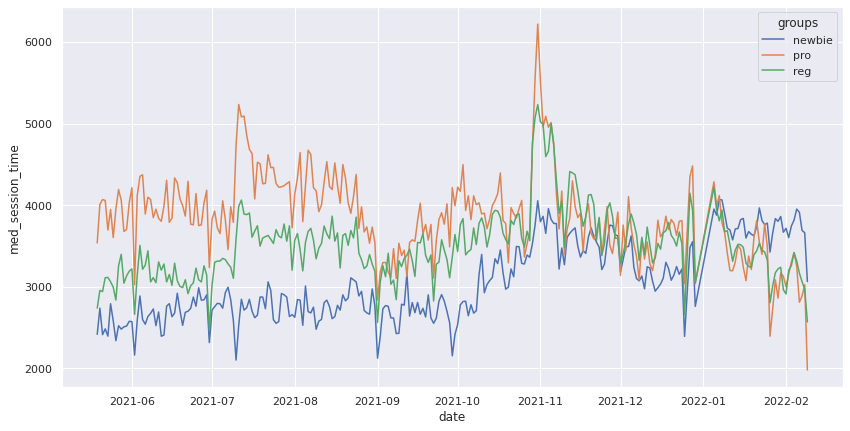

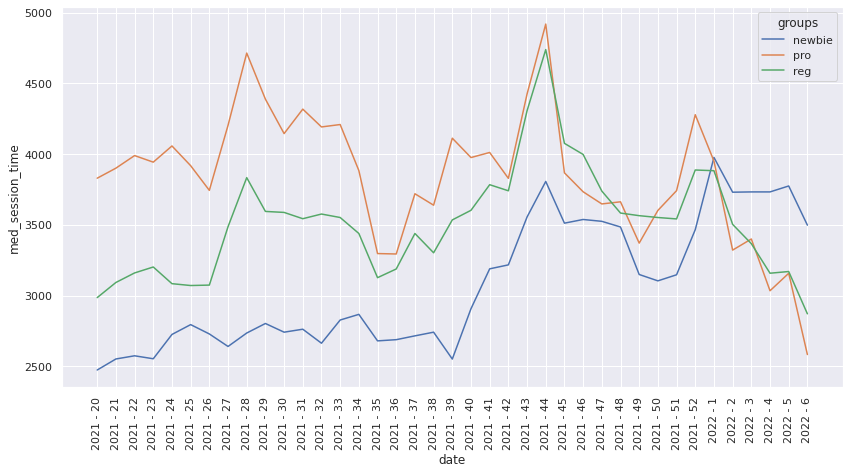

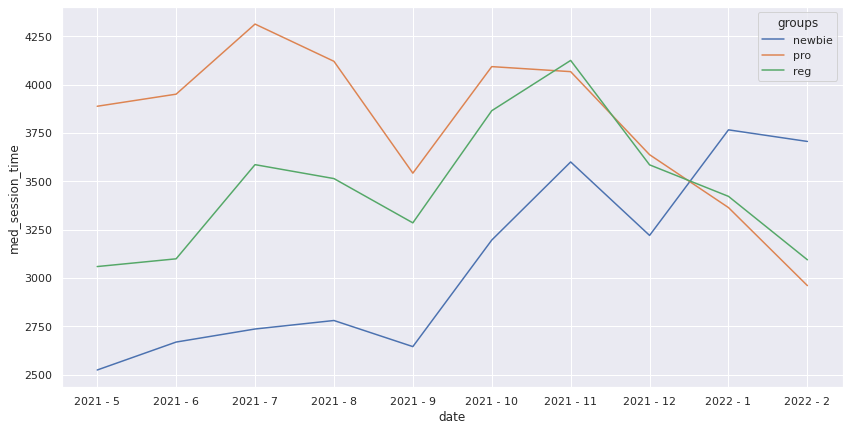

In [112]:
create_lineplots('date', 'med_session_time')

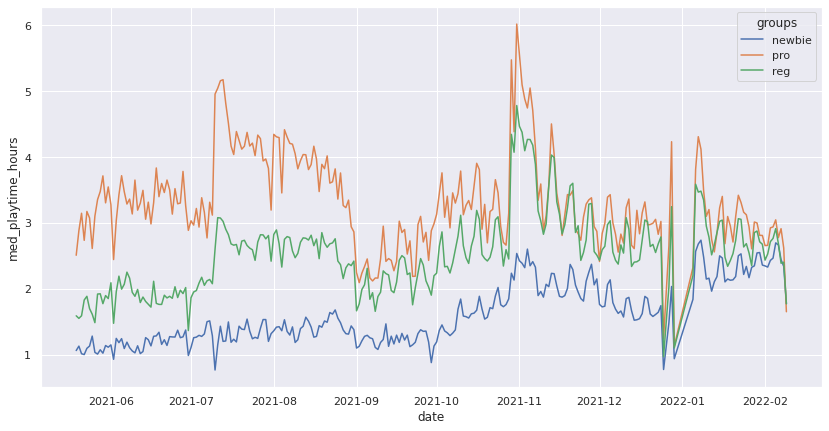

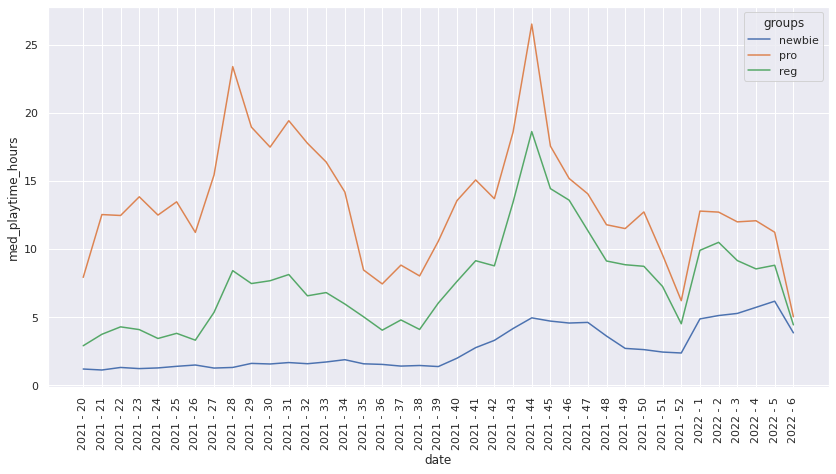

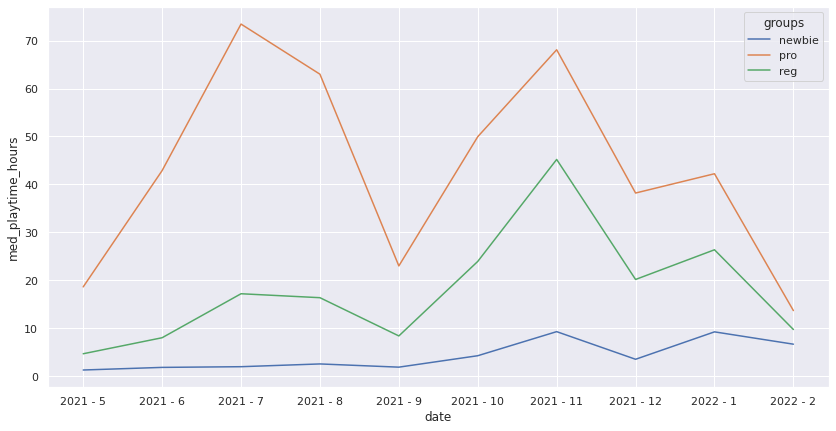

In [114]:
create_lineplots('date', 'med_playtime_hours')

Как по длинне сессии за период, так и времени, очевидно, что группа ветеранов всегда в топе, на втором месте развивающиеся игроки, а на третьем новички. Такая ситуация наблюдалась до октября 2021 года. После октября все эти параметры начинают сближатся, причем из-за увеличения продолжительсти игры у группы новичков и развивающихся игроков. Что больше интересно, на графиках заметна сезонность, связанная.. со школьными каникулами. Пики по времени в игре ровно приходятся на летние шокльные каникулы, а их резкое снижение на 1 сентября, следующий большой пик попадет на конец октября, с резким падением начале ноября, что тоже сообтветсвует осенним каникулам. Подобное поведение больше всего видно на "про" игроках: среднее время провождение в игре возрастает почти в 1,5 раза. (это отлично видно на недельном графике с 42 по 44 недели). Также на графике ежедневной активности локальные экстремумы недельной периодичности обуславливаются выходными: выходной - больше играют. 

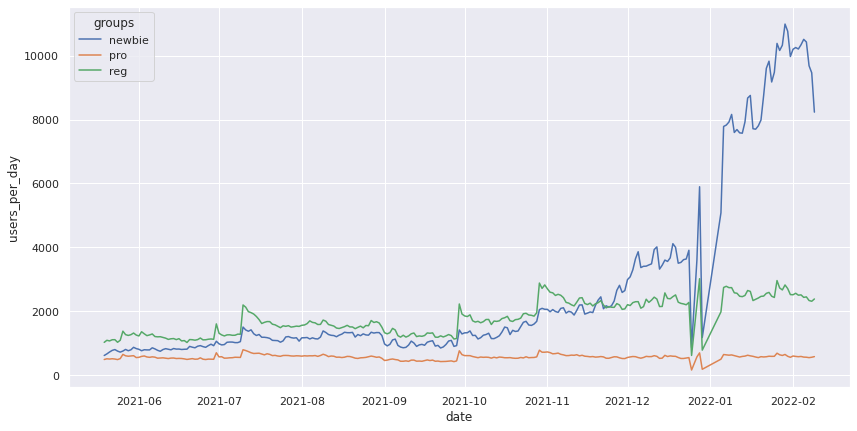

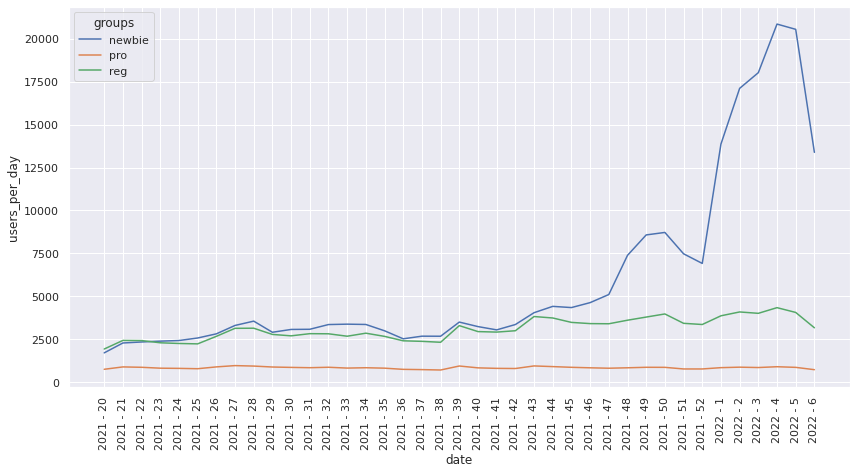

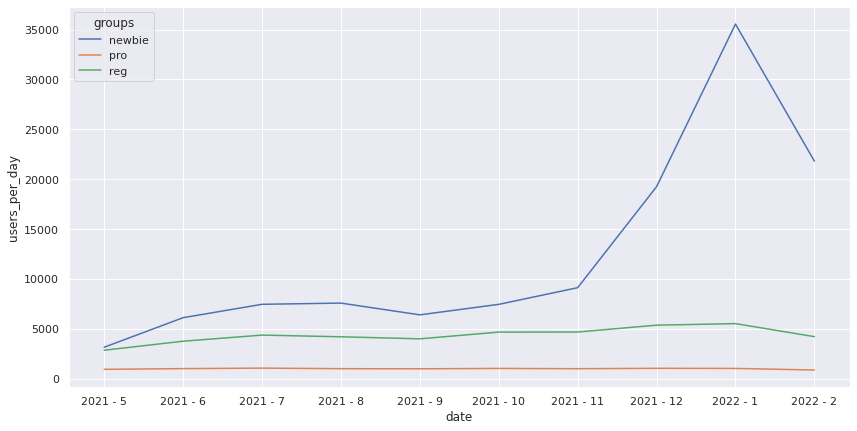

In [109]:
create_lineplots('date', 'users_per_day')

По количеству игроков за разные временные промежутки сложно сказать что-то новое, кроме того, что с декабря 2021 года наблюдается огромный приток новичков. 

In [27]:
#df_faction_logs = pd.read_csv('data/copy_mc_player_faction_logs.csv')
# df_faction_logs.date = pd.to_datetime(df_faction_logs.date)
# df_faction = pd.read_csv('data/copy_mc_player_faction.csv')
# df_faction1 = pd.read_csv('data/copy_mc_player_faction1.csv')
#df_faction_logs

20530